# **Projet SDD - Statistiques : Jeu de données Météo en France**

MAURETTE Audrey / TONON Alexandre / MAIGNAN Alexandre / LE SECQ Antonin / CLAICH Octave

Chaque partie ayant été effectuée par un membre différent de l'équipe, il peut arriver que les mêmes variables/dataframes soient définis à différents endroits du projet, le travail ayant été effectué séparément (après définition des objectifs du groupe).

# Partie 1 - Exploration des données

#### Chargement des librairies et lecture du dataset

In [1]:
library(ggmap)
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(FactoMineR)
library(ggfortify)
library(ggrepel)
library(pls)
library(boot)
library(corrplot)
library(lars)

API_key <- readLines("API.txt",n = 1)
options(repr.plot.width = 12, repr.plot.height = 6)

register_stadiamaps(key = API_key)

Le chargement a nécessité le package : ggplot2

ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.

Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:data.table’:

    between, first, last


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



Attachement du package : ‘pls’


L'objet suivant est masqué depuis ‘package:stats’:

    loadings


corrplot 0.95 loaded


Attachement du package : ‘corrplot’


L'objet suivant est masqué depuis ‘package:pls’:

    corrplot


Loaded lars 1.3


Warning message in readLines("API.txt", n = 1):
“ligne finale incomplète trouvée dans 'API.txt'”


In [46]:
# Lire les données depuis le csv 
df <- read.csv("donnees-synop-essentielles-omm.csv", sep = ";", header = TRUE)

## Description quantitative des données

In [ ]:
cat("Le dataset contient", nrow(df), "lignes (points de mesures) et", ncol(df), "colonnes (paramètres).\n")
cat("Il contient des données météo issues de", length(unique(df$ID.OMM.station)), "stations.\n")

cat("Les données débutent le", min(df$Date), "et se terminent le", max(df$Date), ".\n")

## Répartition temporelle des données
On regarde l'étendue de nos données et les éventuels trous pour ne pas suranalyser des phénomènes plus tard (ex si on a un hiver de + dans les données, cela fausse nos moyennes de température)

In [ ]:
annee <- as.numeric(format(as.Date(df$Date), "%Y"))
mois <- as.numeric(format(as.Date(df$Date), "%m"))

df$Annee <- annee
df$Mois <- mois

In [ ]:
par(bg = "white")
barplot(table(annee),
        main = "Nombre d'observations par année (tous mois confondus)",
        col = "lightblue",
        xlab = "Année",
        ylab = "Nombre d'observations")

En 2025 il est normal qu'il manque quelques mois  
En 2015 en revanche le nombre de données est plus faible. On doit vérifier si l'année est complète ou si quelques mois seulement sont représentés



In [ ]:
cat("En 2016, les mois représentés sont : ", sort(unique(mois[annee == 2015])), "\n")
cat("En 2025, les mois représentés sont : ", sort(unique(mois[annee == 2025])), "\n")

On apprend que le dataset est glissant et qu'on a 10 ans entièrement représentées : cela va nous aider pour nos interprétations. On confirme ca avec l'étude du nombre d'observations par mois, pour vérifier que globalement on a pas une surreprésentation de tel ou tel mois

In [ ]:
par(bg = "white")
barplot(table(mois),
        main = "Nombre d'observations par mois (toutes années confondues)",
        col = "lightblue",
        xlab = "Mois",
        ylab = "Nombre d'observations")

cat("Cette représentation montre que les données sont globalement bien réparties sur les mois.\n")

## Données géographiques

In [ ]:
cat("Le dataset comporte",length(unique(df$communes..code.)), "communes différentes.\n")
cat("Le dataset comporte",length(unique(df$department..code.)), "départements différents.\n")
cat("Le dataset comporte",length(unique(df$region..code.)), "régions différentes.\n")

In [ ]:
# Nombre de stations uniques par année
nb_stations <- tapply(df$ID.OMM.station, df$Annee, function(x) length(unique(x)))

par(bg = "white")
barplot(nb_stations,
        main = "Nombre de stations par année",
        col = "lightblue",
        xlab = "Année",
        ylab = "Nombre de stations")

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)
fr_bbox <- c(left = -6, bottom = 41, right = 10, top = 52)
map <- get_stadiamap(bbox = fr_bbox, zoom = 5, maptype = "stamen_toner_lite")

stations <- unique(df[, c("Longitude", "Latitude")])

ggmap(map) +
geom_point(
    data = stations,
    aes(x = Longitude, y = Latitude),
    color = "red",
    size = 3
  )

options(repr.plot.width = 12, repr.plot.height = 6)

On note qu'il y a 20 stations en dehors de la France métropolitaine

## Qualité

In [ ]:
par(bg = "white")
options(repr.plot.width = 12, repr.plot.height = 6)

na_pct <- colMeans(is.na(as.data.frame(df))) * 100
na_pct <- sort(na_pct, decreasing = TRUE)

barplot(na_pct,
        main = "Pourcentage de NA par variable",
        col = "tomato",
        las = 2,
        ylab = "% de NA",
        cex.names = 0.7)

## Premières Analyses

Cette partie nous a permis de se forger des premières opinions, de chercher des phénomènes à analyser par la suite. Ainsi on va chercher à donner une réalité statistique, à ces observations/ intuitions tout au long des différentes parties.

### Moyenne des températures par année

On va commencer par regarder la température moyenne en France, pour chaque année, afin de voir si elle se conserve ou non. On enlève de l'étude 2015 et 2025, qui ne sont pas complètes dans le jeu de données.

In [ ]:
# On récupère les dates et les températures en degrés Celsius dans un nouveau dataframe 
df_temp_annee <- df[, c("Date", "Température...C.")]

# On convertit les dates pour ne garder que les années
df_temp_annee$Date <- format(as.POSIXct(df$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC"), "%Y")

# On néttoie le datframe des Na et des cases vides
df_temp_annee <- na.exclude(df_temp_annee)
df_temp_annee <- df_temp_annee[df_temp_annee$Date != "", ]
df_temp_annee <- df_temp_annee[df_temp_annee$Température...C. != "", ]

# On récupère les moyennes de température de toutes les stations par années
df_temp_annee <- aggregate(Température...C. ~ Date , data = df_temp_annee, FUN = mean, na.rm = TRUE)

# Comme les années 2015 et 2025 ne sont pac complètent, on les supprime
df_temp_annee <- df_temp_annee[!df_temp_annee$Date %in% c("2015", "2025"), ]

# On trace le graphique de la moyenne de température par année
par(bg = "white")
plot(df_temp_annee$Date, df_temp_annee$Température...C., col = "blue", main= "Graphique de la température moyenne par années", xlab = 'Années', ylab = "Température (C°)")


On note une augmentation globale de la température moyenne annuelle en France, au fil des années, avec simplement une "anomalie" en 2021, où la température est repartie à la baisse, avant d'augmenter à nouveau. On garde tout de même en tête que cette tendance visuelle n'a pour l'instant pas de réalité statistique : c'est l'objet du BE.

  
On va désormais afficher la moyenne des températures mensuelles à Toulouse.

In [ ]:
# On filtre le dataframe uniquement sur Toulouse
df_Toulouse <- df[df$communes..name. == "Blagnac", ]
df_Toulouse <- df[, c("mois_de_l_annee", "Température...C.")]

# On néttoie le datframe des Na et des cases vides
df_Toulouse <- na.exclude(df_Toulouse)
df_Toulouse <- df_Toulouse[df_Toulouse$mois_de_l_annee != "", ]
df_Toulouse <- df_Toulouse[df_Toulouse$Température...C. != "", ]

# On récupère les moyennes de température de Toulouse par mois
df_temp_moi <- aggregate(Température...C. ~ mois_de_l_annee, data = df_Toulouse, FUN = mean, na.rm = TRUE)

In [ ]:
# On trace le graphiques de la moyenne de température par moi sur Toulouse
par(bg = "white")
barplot(names.arg = df_temp_moi$mois_de_l_annee, height = df_temp_moi$Température...C., col = "blue", main= "Distribution de la température moyenne par mois à Toulouse, entre août 2015 et juillet 2025", xlab = 'Moi', ylab = "Température (C°)")


On observe logiquement une augmentation graduelle de la température moyenne à mesure que l'on s'approche de l'été, puis une diminution de cette température à mesure que l'on se rapproche de l'hiver.

## Comparaison entre stations

On va désormais s'intéresser aux différences qui peuvent exister entre les stations de ce jeu de données. On va se concentrer sur 3 lieux : une station dans le Sud de la France (située à Blagnac), une station dans le Nord de la France (située à Carpiquet), et une station en Outre-Mer (située à Saint-Laurent-de-Maroni). Le but des visualisations suivantes sera de distinguer les valeurs de certaines variables pour ces 3 stations.  
  
On se concentre sur l'année 2024 pour ces analyses.

In [ ]:
dt <- as.data.table(df)

In [ ]:
dt_2024 <- dt[Date >= "2024-01-01" & Date <= "2024-12-31"]
dt_caen_2024 <- dt_2024[communes..name. == "Carpiquet"]

dim(dt_caen_2024)

dt_toulouse_2024 <- dt_2024[communes..name. == "Blagnac"]
dim(dt_toulouse_2024)

dt_guyane_2024 <- dt_2024[communes..name. == "Saint-Laurent-du-Maroni"]

dim(dt_guyane_2024)


In [ ]:
dt_caen_2024$Date = as.Date(dt_caen_2024$Date)
dt_toulouse_2024$Date = as.Date(dt_toulouse_2024$Date)


par(bg = "white")

plot(dt_toulouse_2024$Date[!is.na(dt_toulouse_2024$`Température...C.`)],
     dt_toulouse_2024$`Température...C.`[!is.na(dt_toulouse_2024$`Température...C.`)], 
     type = "p",
     col = "blue",
     xlab = "Date", 
     ylab = "Température (°C)", 
     main = "Évolution de la température à Toulouse sur l'année 2024")

plot(dt_toulouse_2024$Date[!is.na(dt_toulouse_2024$`Humidité`)],
     dt_toulouse_2024$`Humidité`[!is.na(dt_toulouse_2024$`Humidité`)], 
     type = "p",
     col = "blue",
     xlab = "Date", 
     ylab = "Taux d'humidité (%)", 
     main = "Évolution de l'humidité à Toulouse sur l'année 2024")

plot(dt_toulouse_2024$Date[!is.na(dt_toulouse_2024$`Précipitations.dans.les.24.dernières.heures`)],
     dt_toulouse_2024$`Précipitations.dans.les.24.dernières.heures`[!is.na(dt_toulouse_2024$`Précipitations.dans.les.24.dernières.heures`)], 
     type = "p",
     col = "blue",
     xlab = "Date", 
     ylab = "Précipitations dans les dern. 24h (mm)", 
     main = "Évolution des précipitations à Toulouse sur l'année 2024")

plot(dt_caen_2024$Date[!is.na(dt_caen_2024$`Précipitations.dans.les.24.dernières.heures`)],
     dt_caen_2024$`Précipitations.dans.les.24.dernières.heures`[!is.na(dt_caen_2024$`Précipitations.dans.les.24.dernières.heures`)], 
     type = "p",
     col = "blue",
     xlab = "Date", 
     ylab = "Précipitations dans les dern. 24h (mm)", 
     main = "Évolution des précipitations à Caen sur l'année 2024")

Pour ce qui est de la température, on retrouve à Toulouse une tendance semblable à ce qu'on avait vu ci-dessus pour les températures moyennes mensuelles dans l'ensemble de la France. Les données d'humidité, présentées sous forme de pourcentages, sont difficilement lisibles ici. Pour ce qui est des précipitations, on semble bien remarquer qu'il pleut plus souvent à Caen qu'à Toulouse dans l'année.

On va ensuite regarder la répartition des données de température dans chaque mois, pour nos 3 stations d'intérêt, pour essayer de déterminer si les échantillons sont similaires ou non.

In [ ]:
par(mfrow = c(1,3), bg = "white")
boxplot(Température...C. ~ mois_de_l_annee, data = dt_toulouse_2024,col = "skyblue",
        main = "Température par mois à Toulouse",
        xlab = "Mois de l'année",
        ylab = "Température (°C)",
        ylim = c(0,40))

boxplot(Température...C. ~ mois_de_l_annee, data = dt_caen_2024,col = "skyblue",
        main = "Température par mois à Caen",
        xlab = "Mois de l'année",
        ylab = "Température (°C)",
        ylim = c(0,40))

boxplot(Température...C. ~ mois_de_l_annee, data = dt_guyane_2024,col = "skyblue",
        main = "Température par mois à Saint-Laurent-du-Maroni",
        xlab = "Mois de l'année",
        ylab = "Température (°C)",
        ylim = c(0,40))

On notera ici que la répartition des températures au sein d'un mois semble suivre la même tendance à Toulouse et à Caen, mais avec des valeurs moyennes légèrement différentes. On pourra s'en servir plus tard lorsque l'on effectuera nos tests d'hypothèses, afin de démontrer que les lois suivies par ces distributions ne possèdent pas les mêmes paramètres.  
On notera en revanche qu'au sein d'un mois, l'étalement des données semble toujours à peu près le même (à part pour janvier à Caen).  
Pour ce qui est du cas de la Guyane, on note une nette différence dans cette distribution par rapport aux autres, avec une température mensuelle moyenne qui se conserve au cours de l'année. Le climat dans cette région n'est pas du tout comparable avec celui en France métropolitaine, ainsi, il conviendra peut-être d'enlever les données issues de départements d'Outre-Mer lors de certaines analyses pour davantage de cohérence (cf histogrammes suivants).

In [ ]:
par(mfrow = c(3,1), bg = "white")
hist(dt_caen_2024$`Température...C.`, xlim = c(0,50), breaks = 50)
hist(dt_toulouse_2024$`Température...C.`, xlim = c(0,50), breaks = 50)
hist(dt_guyane_2024$`Température...C.`, xlim = c(0,50), breaks = 50)

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 6)

ggplot(dt_2024, aes(x = region..name., y = `Température`)) +
  geom_violin(trim = TRUE, fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "white") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Diagramme en violon de la répartition de la température par région en 2024")

Le diagramme en violon ci-dessus traduit également cette observation : les départements d'Outre-Mer représentent un échantillon différent que ceux de France métropolitaine.

In [ ]:
par(bg="white")
pairs(dt_toulouse_2024[, c("Température...C.", "Humidité", "Précipitations.dans.les.24.dernières.heures")],
      main = "Pairs plot des variables d'intérêt")

Lorsque l'on affiche les nuages de points croisés entre la température, l'humidité, et les précipitations sur 24h, on ne semble pas remarquer de corrélation claire pouvant amener à réaliser une régression linéaire. On verra dans la partie dédiée sur quelles variables on pourra observer une corrélation cohérente.

# Partie 2 - Etude d'estimateur

On s'intéresse aux estimateurs de moyenne et estimateurs de variance / ecart type de la température moyenne par mois sur l'année 2018 de Toulouse et de la Guyane. On vas ensuite calculer un intervale de confiance et faire un calcule bootstrap pour voire si les estimateur de moyenne sont asytoptiquement normale.

In [ ]:
# On filtre le dataframe uniquement sur Toulouse
df_Toulouse <- df[df$communes..name. == "Blagnac", ]

# On convertit les dates pour ne garder que l'année 2018
df_Toulouse$Date <- format(as.POSIXct(df_Toulouse$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC"), "%Y")
df_Toulouse <- df_Toulouse[df_Toulouse$Date == "2018", ]

# On récupère les moyennes de température de Toulouse par mois
df_temp_moi_toulouse <- aggregate(Température...C. ~ mois_de_l_annee, data = df_Toulouse, FUN = mean, na.rm = TRUE)

# On nettoie le dataframe des Na et des cases vides
x_temp_Toulouse <- df_temp_moi_toulouse[df_temp_moi_toulouse$Température...C. != "", ]$Température...C.
x_temp_Toulouse <- na.omit(x_temp_Toulouse)

# Calcul de la moyenne empirique
n_Toulouse <- length(x_temp_Toulouse)
mean_empirique_Toulouse <- mean(x_temp_Toulouse)

# Calcul de variance empirique
var_empirique_Toulouse <- var(x_temp_Toulouse)
# Calcul de l'estimateur de variance sans biais
var_empirique_sans_biais_Toulouse <- (n_Toulouse/(n_Toulouse-1)) * var_empirique_Toulouse

# Calcul d'un intervalle de confiance avec alpha = 0.05
IC_3_min <- mean_empirique_Toulouse - sqrt(var_empirique_sans_biais_Toulouse/(0.05 * n_Toulouse))  
IC_3_max <- mean_empirique_Toulouse + sqrt(var_empirique_sans_biais_Toulouse/(0.05 * n_Toulouse))  

IC_3_Toulouse <- c(IC_3_min, IC_3_max)

cat("La moyenne empirique de la Température moyenne de Toulouse par moi sur 2018 est de  :", signif(mean_empirique_Toulouse,3), "\n")
cat("L'écart type de la Température moyenne de Toulouse par moi sur 2018 est de  :", sqrt(var_empirique_Toulouse), "\n")
cat("L'estimateur sans bias de la variance de la Température moyenne de Toulouse par moi sur 2018 est de  :", var_empirique_sans_biais_Toulouse, "\n")
cat("L'intervale de confiance de la moyenne avec un alpha de 5% est de : [", IC_3_Toulouse[1], ", ", IC_3_Toulouse[2], "]")

# On vas faire un calcul bootstrap afin de tester le TCL 

B <- 100  
mean_boot_Toulouse <- numeric(B)  

set.seed(42) # Pour la répétabilité

# On calcule les échantillons Bootstrap et l'estimateur de la moyenne sur chaque
mean_boot_Toulouse <- replicate(B, {
  X_b <- sample(x_temp_Toulouse, size = n_Toulouse, replace = TRUE)
  mean(X_b)                                 
})


# Calcul de la variable centrée réduite
Z_Toulouse <- (mean_boot_Toulouse - mean_empirique_Toulouse) / (sqrt(var_empirique_Toulouse) / sqrt(n_Toulouse))


par(bg= "white")
hist(Z_Toulouse, breaks=30, probability=TRUE, main="Distribution centrée et réduite des moyennes bootstrap", xlab="Valeurs centrées et réduites", col="skyblue")


curve(dnorm(x, mean=0, sd=1), add=TRUE, col="red", lwd=2)

plot(df_temp_moi_toulouse$mois_de_l_annee, x_temp_Toulouse, main = "Température moyenne par mois de Toulouse sur 2018", xlab ="'Moi de l'années", ylab = "Température C°")

On trouve que la moyenne empirique se rapproche beaucoupe d'une moyenne de température d'un pays tempéré, ce qui concorde avec le climat toulousain. De plus, on voit que l'écart-type est de 6°C, cela montre bien que Toulouse possède une météo pouvant descendre bas en hiver et monter haut en été. C'est aussi ce que montre l'intervale de confiance qui est très étendu.  
De plus, on voit bien avec le BootStrap que l'estimateur de la moyenne est bien asymptotiquement normal.

On fait l'hypothèse que la distribution de la température moyenne par mois à Toulouse en 2018 suit une loi normale. On souhaite calculer l'estimateur de maximum de vraisemblance afin de trouver la moyenne et l'écart-type.

In [ ]:
# On crée des listes pour tester les moyenne et les écart-types qui sont centrés sur une étude graphique
mu_list <- seq(12, 17, length.out = 100)
sigma_list <- seq(0, 10, length.out = 100) 

loglik_mat <- matrix(NA, nrow = length(mu_list), ncol = length(sigma_list))

# On calcule la vraisemblance pour chaque paire (mu, sigma)
for (i in seq_along(mu_list)) {
  for (j in seq_along(sigma_list)) {
    loglik_mat[i, j] <- sum(dnorm(x_temp_Toulouse, mean = mu_list[i], sd = sigma_list[j], log = TRUE))
  }
}

# On cherche l'indice de la mu_liste et la sigm_liste qui maximise la vraisemblance
max_idx <- which(loglik_mat == max(loglik_mat), arr.ind = TRUE)

# On récupère la moyenne et l'écart type
mu_hat <- mu_list[max_idx[1]]
sigma_hat <- sigma_list[max_idx[2]]

cat("Avec l'estimateur du maximume de vraisemblance, on a m =", mu_hat, "et sigma = ", sigma_hat )

# Ajouter un equart relatife entre max vraisemblence et estimatuer empirique

L'estimateur du maximum de vraisemblance donne des calculs de moyenne et d'écart-type très proches de la moyenne empirique et de l'écart-type empirique, ce qui est satisfaisant.

In [ ]:
# On filtre le dataframe uniquement sur la Guyane
df_Guyane <- df[df$department..name. == "Guyane", ]

# On convertit les dates pour ne garder que l'année 2018
df_Guyane$Date <- format(as.POSIXct(df_Guyane$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC"), "%Y")
df_Guyane <- df_Guyane[df_Guyane$Date == "2018", ]

# On récupère les moyennes de température de la Guyane par mois
df_temp_moi_Guyane <- aggregate(Température...C. ~ mois_de_l_annee, data = df_Guyane, FUN = mean, na.rm = TRUE)

# On nettoie le dataframe des Na et des cases vides
x_temp_Guyanne <- df_temp_moi_Guyane[df_temp_moi_Guyane$Température...C. != "", ]$Température...C.
x_temp_Guyanne <- na.omit(x_temp_Guyanne)

# Calcul de la moyenne empirique
n_Guyanne <- length(x_temp_Guyanne)
mean_empirique_Guyanne <- mean(x_temp_Guyanne)

# Calcul de variacne empirique
var_empirique_Guyanne <- var(x_temp_Guyanne) 
# calcul de l'estimateur de variance sans biais
var_empirique_sans_biais_Guyanne <- (n_Guyanne/(n_Guyanne-1)) * var(x_temp_Guyanne)

# Calcul d'un intervalle de confiance avec alpha = 0.05
IC_3_min <- mean_empirique_Guyanne - sqrt(var_empirique_Guyanne/(0.05 * n_Guyanne))  
IC_3_max <- mean_empirique_Guyanne + sqrt(var_empirique_Guyanne/(0.05 * n_Guyanne))  

IC_3_Guyanne <- c(IC_3_min, IC_3_max)


cat("La moyenne empirique de la Température moyenne de Guyane par mois sur 2018 est de  :", mean_empirique_Guyanne, '\n')
cat("La variance empirique de la Température moyenne de Guyane par mois sur 2018 est de  :", var_empirique_Guyanne, '\n')
cat("L'estimateur sans biais de la variance de la Température moyenne de Guyane par mois sur 2018 est de  :", var_empirique_sans_biais_Guyanne, '\n')
cat("L'intervale de confiance de la moyenne avec un alpha de 5% est de : [", IC_3_Guyanne[0], ", ", IC_3_Guyanne[1], "]")


# On vas faire un calcul bootstrap afin de tester le TCL 

B <- 100  
mean_boot_Guyanne <- numeric(B)  

set.seed(42) # Pour la répétabilité

# On calcule les échantillons Bootstrap et l'estimateur de la moyenne sur chaque
mean_boot_Guyanne <- replicate(B, {
  X_b <- sample(x_temp_Guyanne, size = n, replace = TRUE)
  mean(X_b)                                 
})
  
# Calcul de la variable centrée réduite
Z_Guyanne <- (mean_boot_Guyanne - mean_empirique_Guyanne) / (sqrt(var_empirique_Guyanne) / sqrt(n_Guyanne))


par(bg= "white")
hist(Z_Guyanne, breaks=30, probability=TRUE, main="Distribution centrée et réduite des moyennes bootstrap", xlab="Valeurs centrées et réduites", col="skyblue")


curve(dnorm(x, mean=0, sd=1), add=TRUE, col="red", lwd=2)

On trouve que la moyenne empirique est de 26°C ce qui colle avec la Guyane, ayant une météo tropicale. De plus, on voit que l'écart-type est très faible, caractéristique des région équatoriales. C'est aussi ce que montre l'intervalle de confiance qui est très serré.  
De plus, on voit bien avec le BootStrap que l'éstimateur de la moyenne est bien asymptotiquement normale.

# Partie 3 - Test Statistique

### Test d'égalité des moyennes

POur poursuivre la recherche de significativité statistiques dans nos observations, on cherche à savoir si la température moyenne de 2024 est différente de celle de 2016. Cela nous donnerait une première indication sur la significativité du réchauffement constaté en première partie.


Pour cela, on pose l’hypothèse nulle (H₀) : les deux moyennes sont égales, et l’hypothèse alternative (H₁) : elles diffèrent. On va réaliser un test de Student

Le test t de Student repose sur plusieurs hypothèses :

- Les échantillons sont indépendants,

- Les distributions de températures sont approximativement normales


In [5]:
df_test <- df
df_test$Date <- as.Date(df_test$Date)

# On récupère les températures de 2016 et 2024
x <- subset(df_test, format(Date, "%Y") == "2016", select = c("Température...C."))
# x <- aggregate(Température...C. ~ mois_de_l_annee, data = x, FUN = mean, na.rm = TRUE)
x <- x[x$Température...C. != "", ]
x <- na.omit(x)

y <- subset(df_test, format(Date, "%Y") == "2024", select = c("Température...C."))
# y <- aggregate(Température...C. ~ mois_de_l_annee, data = y, FUN = mean, na.rm = TRUE)
y <- y[y$Température...C. != "", ]
y <- na.omit(y)

# Test de comparaison des moyennes
resultat_test <- t.test(x, y, var.equal=FALSE)

print(resultat_test)


	Welch Two Sample t-test

data:  x and y
t = -37.991, df = 335116, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.271920 -1.147119
sample estimates:
mean of x mean of y 
 14.48988  15.69940 



La p-value obtenue (< 2.2e-16) est largement inférieure au seuil de 0,05. On rejette donc l’hypothèse nulle (H₀) : la différence entre les moyennes est statistiquement significative.

En 2024, la température moyenne (≈ 15,70 °C) est supérieure d’environ 1,2 °C à celle de 2016 (≈ 14,49 °C).

## Test ANOVA

On cherche à savoir si les moyenne des températures par mois sur chaque année à Toulouse sont les mêmes. Pour ce faire, on vas utiliser un test ANOVA. Notre hypothèse H0 est que les moyennes sont les mêmes et l'hypothèse H1 est qu'elles sont différentes. Notre but est de montrer que les moyennes ne sont plus les mêmes d'année en année, on pourrait alors entrevoir un déréglement des températures (sans surinterpréter nos résultats).

In [ ]:
# On filtre le dataframe uniquement sur Toulouse
df_Toulouse_test <- df[df$communes..name. == "Blagnac", ]

# On récupère les date et les températures en degrés Celsius 
df_Toulouse_test_reduced <- df_Toulouse_test[, c("Date", "Température...C.", 'mois_de_l_annee')]

# On convertie les dates pour ne garder que les années
df_Toulouse_test_reduced$Date <- format(as.POSIXct(df_Toulouse_test_reduced$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC"), "%Y")

# On néttoie le datframe des Na et des cases vides
df_Toulouse_test_reduced <- na.exclude(df_Toulouse_test_reduced)
df_Toulouse_test_reduced <- df_Toulouse_test_reduced[df_Toulouse_test_reduced$Date != "", ]
df_Toulouse_test_reduced <- df_Toulouse_test_reduced[df_Toulouse_test_reduced$Température...C. != "", ]
df_Toulouse_test_reduced <- aggregate(Température...C. ~ Date + mois_de_l_annee, data = df_Toulouse_test_reduced, FUN = mean, na.rm = TRUE)
# Calcule de l'ANOVA
model_année_temp <- aov(Température...C. ~ Date, data= df_Toulouse_test_reduced)

print(summary(model_année_temp))

L’ANOVA sur les températures moyennes mensuelles à Blagnac (F = 0.154, p = 0.999) conduit à ne pas rejeter H₀ : aucune différence significative entre années n’est détectée. L’agrégation par mois réduit la puissance statistique, rendant la détection plus difficile. 

Pour mettre en évidence avec une significativité statistique l’effet du changement climatique à cette échelle, il faudrait soit plus d’années de données, soit une méthode d’analyse plus adaptée (ex. régression temporelle).

## Test de normalité - Shapiro Wilk

On va chercher à savoir si une des variables que l'on maîtrise possède une distribution se rapprochant d'une loi normale. On va donc procéder à un test de Shapiro-Wilk, sur la distribution de pression en 2024 à Toulouse (cf histogramme ci-dessous), dont la répartition semble se rapprocher d'une normale.

In [ ]:
par(bg="white")
hist(dt_toulouse_2024$Pression.station, breaks = 50)

In [ ]:
dim(dt_toulouse_2024)
shapiro.test(dt_toulouse_2024$Pression.station)

Le test nous rend une p-value très proche de 0, l'hypothèse de normalité est donc rejetée ici. Cela peut s'expliquer par le fait que, même si l'on s'est restreint à une ville et une année, le nombre de points reste très important (2918 points), ainsi le moindre écart entre les données et une loi normale fait plonger la p-value. Ainsi, on ne pourra pas estimer à l'aide de ce test que la pression suit une loi normale.

In [ ]:
dt_toulouse_juillet_2024 <- dt_toulouse_2024[mois_de_l_annee == '7']
dim(dt_toulouse_juillet_2024)
par(bg = "white")
hist(dt_toulouse_juillet_2024$`Température...C.`, xlim = c(0,40), breaks = 50)

# Partie 4

## Etude de correlation

Pour observer nos données sous un autre angle, on regarde les coefficients de Pearson entre différentes variables 

In [ ]:
columns <- c('Latitude', 'Longitude', 'Altitude', 'Température...C.', 'Pression.station')

df_pos_temp <- df[, columns]
df_pos_temp <- na.exclude(df_pos_temp)

cor(df_pos_temp, method = "pearson", use="pairwise.complete.obs")
cor_person <- cor(df_pos_temp)

par(bg = "white")
corrplot(cor_person, method = "color")

## Regression Température = f (Année)
On fait une régression linéaire sur les températures moyennes annuelles (après nettoyage des données et exclusion des années 2015 et 2025 qui sont incomplètes) afin d’analyser la tendance de leur évolution au fil du temps.

In [49]:
# Renommer la colonne Date en Datetime
df_test <- df

# Filtrage des lignes valides
df_test <- df_test[!is.na(df_test$Température) & !is.na(df_test$Date), ]

start <- as.POSIXct("2025-01-01 12:00:00", tz = "UTC")
end   <- as.POSIXct("2025-01-01 12:59:59", tz = "UTC")

df_subset <- df_test[df_test$Date >= start & df_test$Date <= end, ]

df_subset


# Régression linéaire uniquement si le sous-ensemble contient assez de données
if (nrow(df_subset) > 1) {
  model_trend <- lm(Température...C. ~ Altitude, data = df_subset)
  print(summary(model_trend))
  
  # Graphique
  par(bg = "white")
  plot(
    df_subset$Altitude, df_subset$Température...C.,
    main = "Température vs Altitude (1er janvier 2025, 12h)",
    xlab = "Altitude (m)", ylab = "Température (°C)",
    pch = 19, col = "darkblue"
  )
  abline(model_trend, col = "red", lwd = 2)
  
  legend("topright",
         legend = c("Données observées", "Régression linéaire"),
         col = c("darkblue", "red"),
         pch = c(19, NA),
         lty = c(NA, 1),
         lwd = c(NA, 2))
} else {
  warning("Pas assez de données dans df_subset pour ajuster une régression linéaire.")
}


Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
<int>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>


Warning message:
“Pas assez de données dans df_subset pour ajuster une régression linéaire.”


Le R² de 0.53 indique que le modèle n'a pas capturé toute la variabilité des données. Pour autant, le test de Fisher inclut dans l'implémentation de lm, qui compare notre regression à un modèle constant obtient un résultat (p = 0,015) qui confirme un lien significatif entre l’année et la température moyenne annuelle en France, mettant en évidence une tendance à la hausse.

### Regression Pression = f(température)


Call:
lm(formula = Pression.station ~ Altitude, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7641.9  -357.8    40.6   490.3  5820.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.014e+05  8.347e-01  121532   <2e-16 ***
Altitude    -1.105e+01  3.584e-03   -3083   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 888.5 on 1685989 degrees of freedom
  (33576 observations effacées parce que manquantes)
Multiple R-squared:  0.8493,	Adjusted R-squared:  0.8493 
F-statistic: 9.503e+06 on 1 and 1685989 DF,  p-value: < 2.2e-16


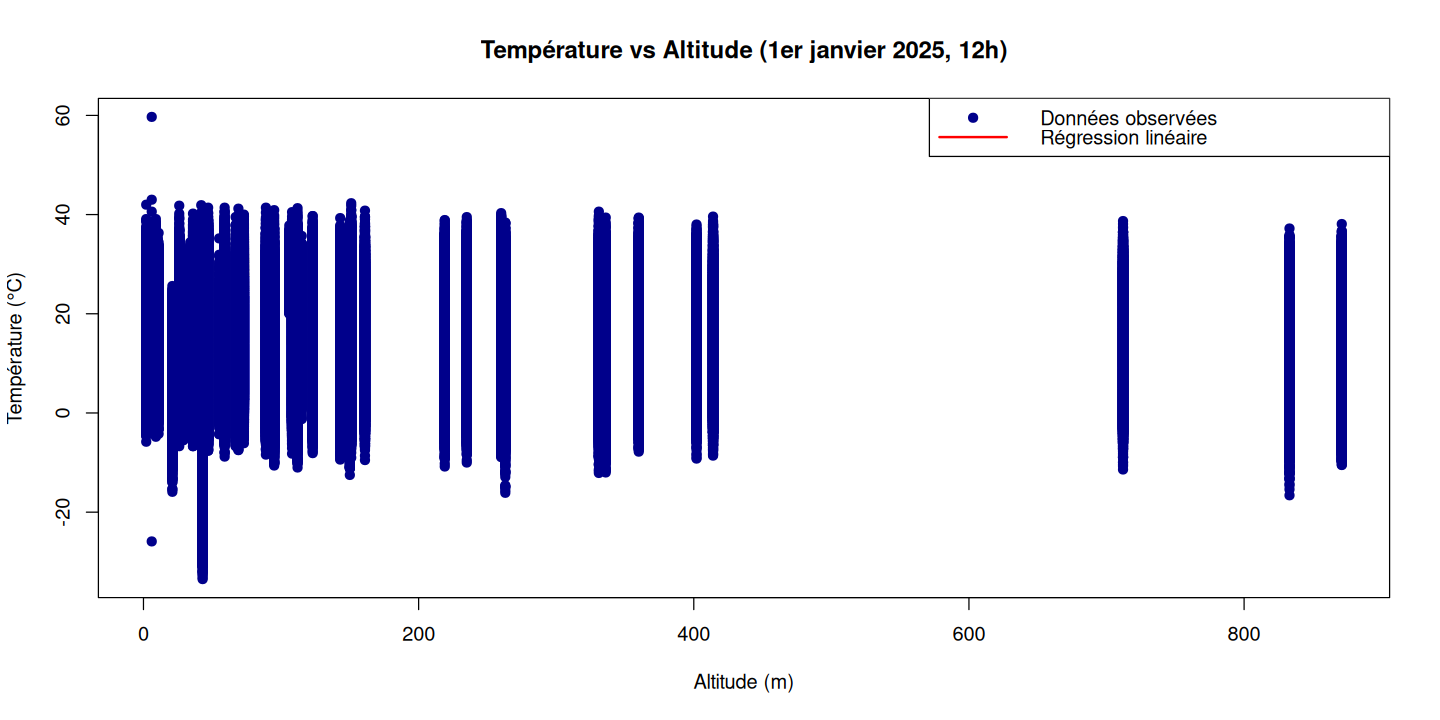

In [8]:
# Régression linéaire
model_trend <- lm(Pression.station ~ Altitude, data = df)
summary(model_trend)

par(bg = "white")

plot(
  df$Altitude, df$Température...C.,
  main = "Température vs Altitude (1er janvier 2025, 12h)",
  xlab = "Altitude (m)", ylab = "Température (°C)",
  pch = 19, col = "darkblue"
)
abline(model_trend, col = "red", lwd = 2)

legend("topright",
       legend = c("Données observées", "Régression linéaire"),
       col = c("darkblue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))


### Lasso

In [ ]:
cols_basics <- c(
  "Pression.au.niveau.mer",
  "Direction.du.vent.moyen.10.mn",
  "Vitesse.du.vent.moyen.10.mn",
  "Température",
  "Humidité",
  "Visibilité.horizontale",
  "Pression.station",
  "Rafale.sur.les.10.dernières.minutes",
  "Altitude",
  "Précipitations.dans.les.3.dernières.heures"
)

# Sous-dataframe
df_sub <- df[, cols_basics]

# Conversion en numérique + nettoyage
df_sub <- data.frame(lapply(df_sub, function(x) as.numeric(as.character(x))))
df_sub <- na.omit(df_sub)

# Variables explicatives (X) et cible (y)
X <- as.matrix(df_sub[, !names(df_sub) %in% "Précipitations.dans.les.3.dernières.heures"])
y <- df_sub$Précipitations.dans.les.3.dernières.heures

# LASSO
model_lasso <- lars(X, y, type = "lasso")

# Validation croisée k-fold (par défaut K=10, tu peux changer)
set.seed(123)  # reproductibilité
cv_lasso <- cv.lars(X, y, K = 10, type = "lasso")

# Plot des erreurs de CV
plot(cv_lasso$cv, type = "o", pch = 19, col = "darkblue",
     main = "Erreur de validation croisée (10-fold) pour LASSO",
     xlab = "Complexité du modèle (step)",
     ylab = "Erreur moyenne de prédiction")
points(which.min(cv_lasso$cv), min(cv_lasso$cv), col = "red", pch = 19, cex = 1.5)
legend("topright", legend = c("Erreur CV", "Modèle optimal"), 
       col = c("darkblue", "red"), pch = 19)

summary(model_lasso)


## Partie 5 : ACP et PLS

### ACP

On va procéder à une ACP sur un extrait de notre jeu de données, afin de visualiser davantage où se placent certaines stations concernant plusieurs variables. Les variables que nous allons considérer sont les valeurs moyennes annuelles, pour chaque station, des données suivantes : vitesse du vent moyen sur 10 minutes, humidité, pression de la station, température, et précipitations dans les 3 dernières heures.

### ACP Octave

In [ ]:
variables_acp = c('communes..name.','Vitesse.du.vent.moyen.10.mn','Humidité','Pression.station', 'Température...C.',
'Précipitations.dans.les.3.dernières.heures')

In [ ]:
dt_2024$Annee <- format(as.Date(dt_2024$Date), "%Y")

# On filtre notre dataframe sur les variables souhaitées
df_acp <- as.data.frame(dt_2024[, ..variables_acp])

# On nettoie le dataframe
df_acp <- df_acp[df_acp$communes..name. != "", ]
df_acp <- df_acp[df_acp$Température...C. != "", ]
df_acp <- df_acp[df_acp$Vitesse.du.vent.moyen.10.mn != "", ]
df_acp <- df_acp[df_acp$Humidité != "", ]
df_acp <- df_acp[df_acp$Pression.station != "", ]
df_acp <- df_acp[df_acp$Précipitations.dans.les.3.dernières.heures != "", ]

df_acp <- na.omit(df_acp)

# On calcule la moyenne sur les communes de chaque variable et on passe le nom des communes en nom de ligne
df_acp <- aggregate(. ~ communes..name., data = df_acp, FUN = mean)

df_acp <- as.data.frame(df_acp) 
rownames(df_acp) <- df_acp$communes..name.
df_acp$communes..name.<- NULL

head(df_acp)

Une fois le dataframe contenant les valeurs moyennes annuelles formé, on peut réaliser l'ACP de ces données, et les représenter sur un graphique avec d'une part, les directions des différentes variables concernées dans le plan principal de l'ACP, et d'autre part, les positions des différentes stations dans ce plan.

In [ ]:
acp <- prcomp(df_acp, center = TRUE, scale. = TRUE)
par(bg = "white")
autoplot(acp, data = df_acp,
         colour = NA,        
         loadings = TRUE,
         loadings.label = TRUE) +
  geom_point(size = 3, color = "blue") +
  geom_text_repel(aes(label = rownames(df_acp)), size = 3)

On note tout d'abord les directions indiquées par les variables originelles dans notre plan principal : les précipitations et l'humidité pointent tous deux vers en haut à gauche du graphique, tandis que la vitesse du vent pointe en bas à droite, et la température et la pression pointent vers en bas à gauche. On note donc des influences différentes de chaque variable au sein de notre plan principal.  
  
On note aussi les pourcentages d'inertie des deux composantes principales de notre modèle, en les sommant on arrive à une part d'inertie de 63,81 %, qui n'est pas idéale mais reste satisfaisante (environ 2/3 des informations des valeurs propres de la matrice de corrélation sont contenues dans les 2 considérées ici).  
  

On peut maintenant s'intéresser à la position des différents points dans notre plan principal. Les points situés dans le coin supérieur droit de notre graphique correspondent aux stations d'Embrun et de Chaspuzac, qui sont tous deux situés en montagne. Ce sont sûrement parmi les points d'altitude la plus élevée parmi les stations considérées. Ainsi, il paraît logique que ce soient ceux ayant la pression moyenne la plus faible, comme observé sur l'ACP (ils sont à l'opposé de la direction donnée par la pression de la station).  
  
Les 4 points situés dans le coin supérieur gauche de l'ACP sont des points de stations situées en Guyane, où le climat équatorial est très humide et comporte de nombreuses pluies diluviennes. Il est donc également logique de les voir situés dans cette zone de l'ACP.  
  
Enfin, on pourra également noter le point représentant l'archipel des Kerguelen (situé en pleine mer), forcément sujet à beaucoup plus de vent que les autres.  
  
Les résultats de l'ACP semblent donc logique. On peut terminer cette section en se demandant s'il n'aurait pas été plus judicieux de choisir d'autres variables à mettre en évidence, car il y a tout de même une grosse zone centrale où sont la plupart des points. Où alors il aurait peut-être fallu exclure les valeurs extrêmes (les stations d'Outre-Mer), puisque l'on savait déjà que le climat n'était pas le même.

## PLS - to be continued


On va faire le calcul de la PLS en regardant le même dataframe, mais, cette fois-ci, on veut regarder le lien entre toute les variables et les précipitations sur les 3 dernières heures.

In [ ]:
# Calcul de la PLS
model_pls <- plsr(Précipitations.dans.les.3.dernières.heures ~ ., data = df_acp, scale = TRUE, validation = "CV" )
summary(model_pls)

# Caclul de l'erreur du modèle PLS
rmsep_pls <- RMSEP(model_pls)$val[1,,]

# On plot l'erreur en fonction du nombre de paramètres gardés
par(bg="white")
plot(rmsep_pls, type = "b", col = "blue", pch = 19,
     xlab = "Nombre de composantes", ylab = "RMSEP",
     main = "RMSE PLS")


legend("topright", legend = "PLS",
       col = "blue", pch = 19, lty = 1)

var_expl_y <- R2(model_pls, estimate = "train")$val[1, , ] * 100

plot(var_expl_y, type = "b", col = "red", pch = 19, main = "Variance Expliquer en fonction du nombre de paramètre",
      xlab = "Nombre de composantes", ylab = "variance expliquée", ylim = c(0, 100))

legend("bottomright", legend = "Y variance expliquée", col = "red", pch = 19, lty = 1)

On peut voir ici avec la PLS, et nottament le graphique de la RMSE en fonction du nombre de paramètre que au bout de deux paramètre, on a déjà une erreur faible. On peut observer un plateau dès deux paramètre qui montre que entre 2 ou 5 paramètre, l'information gagner sur la prédiction n'est pas significative.
De plus, cela rejoint la varaince expliquer dans le second graphique. on voit que avec 2 paramètre, la pls arrive déja a bien récupérere la plus part de l'information et l'ajoue d'autre paramètre ne change pas vraiment cet information. 

# Clustering

## Déterminer les différents climats en france

On va chercher à créer différents groupes, afin de classer les stations représentées dans ce jeu de données, pour repérer des climats similaires en France. On va, pour cela, se baser sur les températures moyennes mensuelles dans chaque station, ainsi que sur les taux d'humidités moyens mensuels dans chaque station (soit 24 variables).  
  
On va utiliser la méthode KMeans pour créer 6 groupes que l'on espère similaires.  
On s'est pour l'instant heurté à des erreurs liées à une taille de nos données trop importante pour réaliser une Classification Ascendante Hiérarchique, donc les centres de départs de notre méthode KMeans seront choisis aléatoirement.  
  
On va commencer par créer le dataframe contenant les valeurs moyennes de température et d'humidité par mois, pour chaque station. On va ensuite standardiser ces données, car l'humidité est un pourcentage, et la température une valeur en °C, donc la différence d'unités aurait forcément donné plus de poids à l'humidité (on n'atteint rarement 90°C il me semble).


In [ ]:
df_moy <- df %>%
  group_by(communes..name., mois_de_l_annee) %>%
  summarise(Temp_moy = mean(`Température...C.`, na.rm = TRUE),
    Hum_moy  = mean(Humidité, na.rm = TRUE),
    .groups = "drop")

df_clustering <- df_moy %>%
  pivot_wider(
    names_from = mois_de_l_annee,
    values_from = c(Temp_moy, Hum_moy),
    names_sep = "_"
  )

df_clustering <- as.data.frame(df_clustering) 
rownames(df_clustering) <- df_clustering$communes..name.
df_clustering$communes..name. <- NULL

df_clustering <- scale(df_clustering)

head(df_clustering)

In [ ]:
dim(df_clustering)

Erreur liée au calcul de la Classification en Ascendance Hiérarchique :

In [ ]:
distances = dist(df_clustering)
cah = hclust(df_clustering, method = "complete")
groupes = cutree(cah_ward, k = 6)


In [ ]:
kmeans <- kmeans(df_clustering, centers=6)
cat("Groupes des individus pour la méthode K-means :\n")
print(kmeans$cluster)

Les stations sont donc classées dans 6 groupes après application de l'algorithme de KMeans. On va essayer de visualiser ces groupes sur le graphe d'une ACP, afin de distinguer si les membres d'un même groupe semblent effectivement correspondre à des stations de climat semblable.  
  
L'ACP est effectuée sur les variables choisies pour le clustering (les 24 valeurs moyennes mensuelles).

In [ ]:
acp_clustering <- prcomp(df_clustering)
colors <- c("red", "blue", "green", "black", "orange", "pink")
point_colors <- colors[kmeans$cluster]
par(bg = "white")
plot(acp_clustering$x[,1], acp_clustering$x[,2], 
     col = point_colors, 
     pch = 19,
     xlab="PC1", ylab="PC2",
     main="ACP avec couleurs selon l'algo KMeans")

text(acp_clustering$x[,1], acp_clustering$x[,2], 
     labels = rownames(df_clustering), 
     pos = 3,
     cex = 0.7)
     
legend("topright", legend = paste("Cluster", 1:5), col=colors, pch=19)
abline(v = 0, lty = 2, col = "black")
abline(h = 0, lty = 2, col = "black")

Au vu de ce graphique, on note que les 6 groupes obtenus semblent bien distincts (ils ne sont pas mélangés dans l'ACP). On note immédiatemment que deux groupes sont très différents des autres (en orange et rose sur le graphe), et en regardant les stations concernées, on réalise qu'il s'agit des stations d'Outre-Mer, ce qui semble plutôt logique étant donné la différence de climat avec la métropole.  

On aurait pu réaliser la même analyse en enlevant les données d'Outre-Mer pour avoir moins d'écarts, mais au moins ces différences sont bien mises en évidence.  
Ensuite, on remarque que le groupe bleu correspond majoritairement à des stations situées au Sud de la France (Nice, Ajaccio, Marignane...), et le groupe rouge correspond majoritairement à des stations au Nord de la France (Abbeville, La Hague, Perros-Guirec, ...).  
  
Le résultat de ce clustering semble donc plutôt cohérent, mais il aurait pu être davantage optimisé en choisissant d'autres variables pour le réaliser (les précipitations par exemple).